# TF-MoDISco on the Nanog GkmExplain Scores

This notebook demonstrates running TF-MoDISco on importance scores obtained from GkmExplain on Nanog ChIP-seq data in H1ESCs. See https://github.com/kundajelab/gkmexplain/blob/master/lsgkmexplain_Nanog.ipynb for a notebook demonstrating how to produce the scores.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os

TF-MoDISco is using the TensorFlow backend.
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/a

3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


/Users/avantishrikumar/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Grab the input data

In [3]:
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/positives_test.fa.gz -O positives_test.fa.gz
!gunzip positives_test.fa.gz 
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/gkmexplain_positives_impscores.txt.gz -O gkmexplain_positives_impscores.txt.gz
!gunzip gkmexplain_positives_impscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/gkmexplain_positives_hypimpscores.txt.gz -O gkmexplain_positives_hypimpscores.txt.gz
!gunzip gkmexplain_positives_hypimpscores.txt.gz
!wget https://raw.githubusercontent.com/AvantiShri/model_storage/c8ebc38/modisco/gkmexplain_scores/gkmexplain_dnshuff_impscores.txt.gz -O gkmexplain_dnshuff_impscores.txt.gz
!gunzip gkmexplain_dnshuff_impscores.txt.gz

--2020-04-15 04:32:50--  https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/positives_test.fa.gz
Resolving raw.githubusercontent.com... 151.101.40.133
Connecting to raw.githubusercontent.com|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75038 (73K) [application/octet-stream]
Saving to: 'positives_test.fa.gz'

100%[======================================>] 75,038      --.-K/s   in 0.03s   

2020-04-15 04:32:50 (2.31 MB/s) - 'positives_test.fa.gz' saved [75038/75038]

--2020-04-15 04:32:51--  https://raw.githubusercontent.com/AvantiShri/model_storage/2e603c/modisco/gkmexplain_scores/gkmexplain_positives_impscores.txt.gz
Resolving raw.githubusercontent.com... 151.101.40.133
Connecting to raw.githubusercontent.com|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1000384 (977K) [application/octet-stream]
Saving to: 'gkmexplain_positives_impscores.txt.gz'

100%[=========

### Read in the one-hot encoded sequences and scores

In [4]:
import numpy as np

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
#read in the fasta files and one-hot encode
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open("positives_test.fa"))
              if i%2==1]
#filter out any sequences that contain 'N's
onehot_data = [np.array(one_hot_encode_along_channel_axis(x))
                         for x in fasta_seqs if ('N' not in x)]
print("Num onehot sequences:",len(onehot_data))

#read in the importance scores and hypothetical importance scores
#filter out any sequences that contain 'N's
hyp_impscores = [w[0] for w in zip([
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_positives_hypimpscores.txt")
],fasta_seqs) if 'N' not in w[1]]

impscores = [w[0] for w in zip([
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_positives_impscores.txt")
],fasta_seqs) if 'N' not in w[1]]

#Perform a sanity check to make sure that the importance score are the same as the
# hypothetical scores multiplied elementwise with the one-hot encoding; for this
# reason, it is not technically necessary to compute the importance scores if the
# hypothetical scores are also computed
assert (np.max([np.max(np.abs(z*y - x)) for x,y,z in zip(impscores,onehot_data,hyp_impscores)]))==0

#Read in scores on the dinucleotide-shuffled sequences, taking
# the sum across ACGT at each position, to get an empirical null distribution
# of per-position importance scores
nulldist_perposimp = [
    np.array( [sum([float(z) for z in y.split(",")]) for
                y in x.rstrip().split("\t")[2].split(";")])
    for x in open("gkmexplain_dnshuff_impscores.txt")]

Num onehot sequences: 960


NOTE: in the original GkmExplain paper, a normalization of the importance scores and hypothetical importance scores was proposed, as this was empirically observed to improve the signal-to-noise ratio. For simplicity, we are not applying that normalization here. For details on that normalization, see the Nanog TF-MoDISco notebook in the GkmExplain repo: https://github.com/kundajelab/gkmexplain/blob/master/lsgkmexplain_Nanog.ipynb

Sanity check the scores by plotting

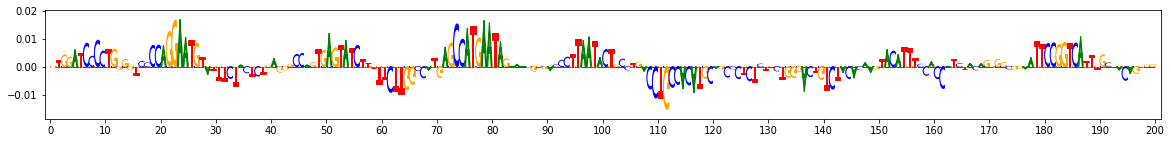

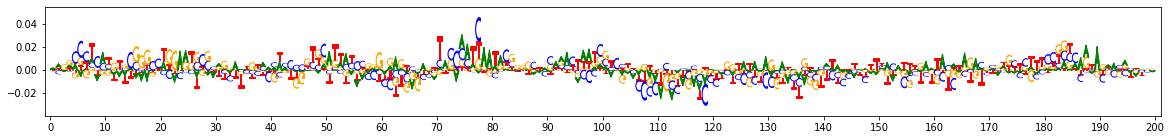

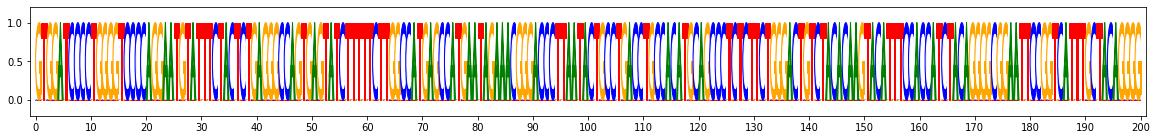

In [5]:
from matplotlib import pyplot as plt
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(hyp_impscores[0], subticks_frequency=10)
viz_sequence.plot_weights(onehot_data[0], subticks_frequency=10)


## Run TF-MoDISco

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- An empirical null distribution is supplied for per-position importance scores using the argument `null_per_pos_scores`
- `target_seqlet_fdr` controls the noisiness of the seqlets. For a particular task, importance scores are first smoothed with a window of size `sliding_window_size` (default value of 21 at the time of writing), and the FDR for scores in sliding windows is estimated using the supplied empirical null distribution. This is used to set a threshold on sliding windows that can go on to form seqlets. Note: if the number of sliding windows that pass the FDR threshold is smaller than `min_passing_windows_frac` (default value 0.03 at the time of writing) or larger than `max_passing_windows_frac` (default value of 0.2 at the time of writing), the threshold will be adjusted.
- The code below uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine on more modern GPUs than the one in my 4-year-old macbook.

MEMORY 0.566075392
On task task0
Computing windowed sums on original
Generating null dist
Computing threshold


TF-MoDISco is using the TensorFlow backend.


Thresholds from null dist were -0.32632443699999997  and  0.26635030000000004
Final raw thresholds are -0.32632443699999997  and  0.26635030000000004
Final transformed thresholds are -0.9486284722222222  and  0.9078125


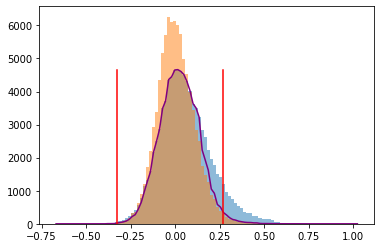

Got 974 coords
After resolving overlaps, got 974 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9077125
MEMORY 0.580571136
974 identified in total
1 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  [936]
Idx to activities:  {0: '1'}
MEMORY 0.580571136
On metacluster 0
Metacluster size 936
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 936
(Round 1) Computing coarse affmat
MEMORY 0.581689344
Beginning embedding computation
Computing embeddings
Finished embedding computation in 5.55 s
Starting affinity matrix computations
Normalization computed in 0.1 s
Cosine similarity mat computed in 0.15 s
Normalization computed in 0.07 s
Cosine similarity mat computed in 0.12 s
Finished affinity matrix computations in 0.29 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 0.704933888
Computed nearest neighbors in 0.13 s
MEMORY 0.719147008
(Round 1) Computi

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.4573389292197394


  2%|▏         | 1/50 [00:00<00:07,  6.68it/s]

Quality: 0.4577179099327294


 84%|████████▍ | 42/50 [00:08<00:01,  4.06it/s]

Quality: 0.4578604312539208


 86%|████████▌ | 43/50 [00:08<00:01,  4.21it/s]

Quality: 0.4580134620428077


 92%|█████████▏| 46/50 [00:08<00:00,  5.16it/s]

Quality: 0.4581163820880825


100%|██████████| 50/50 [00:09<00:00,  5.24it/s]

Got 14 clusters after round 1
Counts:
{1: 105, 4: 51, 6: 43, 2: 64, 11: 13, 0: 122, 5: 46, 3: 51, 7: 42, 9: 31, 8: 34, 10: 23, 13: 7, 12: 13}
MEMORY 0.59867136
(Round 1) Aggregating seqlets in each cluster
MEMORY 0.59867136
Aggregating for cluster 0 with 122 seqlets
MEMORY 0.59867136


Trimmed 3 out of 122
Skipped 19 seqlets
Aggregating for cluster 1 with 105 seqlets
MEMORY 0.59867136
Trimmed 10 out of 105
Skipped 11 seqlets
Aggregating for cluster 2 with 64 seqlets
MEMORY 0.59867136
Trimmed 5 out of 64
Skipped 6 seqlets
Aggregating for cluster 3 with 51 seqlets
MEMORY 0.59867136
Trimmed 1 out of 51
Skipped 10 seqlets
Aggregating for cluster 4 with 51 seqlets
MEMORY 0.59867136
Trimmed 4 out of 51
Skipped 7 seqlets
Aggregating for cluster 5 with 46 seqlets
MEMORY 0.59867136
Trimmed 1 out of 46
Skipped 9 seqlets
Aggregating for cluster 6 with 43 seqlets
MEMORY 0.59867136
Trimmed 4 out of 43
Skipped 10 seqlets
Aggregating for cluster 7 with 42 seqlets
MEMORY 0.59867136
Trimmed 4 out of 42
Skipped 2 seqlets
Aggregating for cluster 8 with 34 seqlets
MEMORY 0.59867136
Trimmed 5 out of 34
Skipped 2 seqlets
Aggregating for cluster 9 with 31 seqlets
MEMORY 0.59867136
Trimmed 0 out of 31
Skipped 3 seqlets
Aggregating for cluster 10 with 23 seqlets
MEMORY 0.59867136
Trimmed 0 o

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.5407356961095008


 32%|███▏      | 16/50 [00:01<00:04,  7.95it/s]

Quality: 0.5410792647448296


100%|██████████| 50/50 [00:05<00:00,  8.58it/s]

Got 8 clusters after round 2
Counts:
{3: 78, 1: 100, 2: 86, 6: 36, 4: 71, 5: 37, 0: 107, 7: 9}
MEMORY 0.595816448
(Round 2) Aggregating seqlets in each cluster
MEMORY 0.595816448
Aggregating for cluster 0 with 107 seqlets
MEMORY 0.595816448


Trimmed 12 out of 107
Skipped 5 seqlets
Aggregating for cluster 1 with 100 seqlets
MEMORY 0.595816448
Trimmed 7 out of 100
Skipped 7 seqlets
Aggregating for cluster 2 with 86 seqlets
MEMORY 0.595816448
Trimmed 26 out of 86
Aggregating for cluster 3 with 78 seqlets
MEMORY 0.595816448
Trimmed 9 out of 78
Skipped 2 seqlets
Aggregating for cluster 4 with 71 seqlets
MEMORY 0.595816448
Trimmed 7 out of 71
Skipped 5 seqlets
Removed 1 duplicate seqlets
Aggregating for cluster 5 with 37 seqlets
MEMORY 0.595816448
Trimmed 0 out of 37
Skipped 4 seqlets
Aggregating for cluster 6 with 36 seqlets
MEMORY 0.595816448
Trimmed 6 out of 36
Aggregating for cluster 7 with 9 seqlets
MEMORY 0.595816448
Trimmed 0 out of 9
Got 8 clusters
Splitting into subclusters...
MEMORY 0.595816448
Inspecting for spurious merging
Wrote graph to binary file in 0.017319917678833008 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.00616587
Louvain completed 21 runs in 0.281689167022705

In [13]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.tfmodisco_workflow
reload(modisco.tfmodisco_workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
            target_seqlet_fdr=0.25,
            seqlets_to_patterns_factory=
                modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                    #initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
                    #    meme_command="meme", base_outdir="meme_out",            
                    #    num_seqlets_to_use=10000, nmotifs=5, n_jobs=1),
                    
                    #Adjust trim_to_window_size and initial_flank_to_add
                    # according to how big you expect
                    # the core motif to be; default value is 10
                    #trim_to_window_size=6,
                    #initial_flank_to_add=2,
                    #final_flank_to_add=5,
                    #kmer_len, num_gaps and num_mismatches are used to
                    # derive kmer embeddings for coarse-grained affinity
                    # matrix calculation. kmer_len=6, num_gaps=1
                    # and num_mismatches=0 means
                    # that kmer embeddings using 6-mers with 1 gap will be
                    # used.
                    kmer_len=6, num_gaps=1,
                    num_mismatches=0,
            ),
       )(
    #There is only one task, so we just call this 'task0'
    task_names=["task0"],
    contrib_scores={'task0': impscores},                
    hypothetical_contribs={'task0': hyp_impscores},
    one_hot=onehot_data,
    null_per_pos_scores={'task0': nulldist_perposimp})

## Save and print the results

In [7]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

Metaclusters heatmap


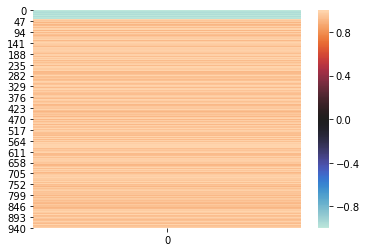

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 198
Hypothetical scores:


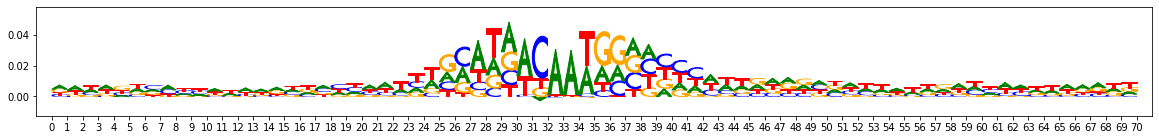

Actual importance scores:


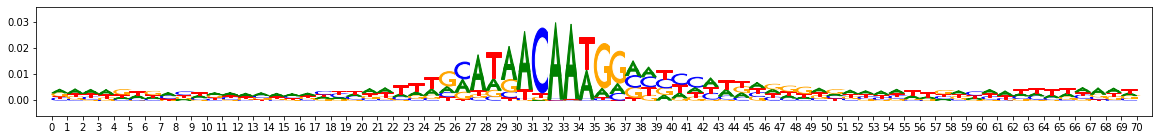

onehot, fwd and rev:


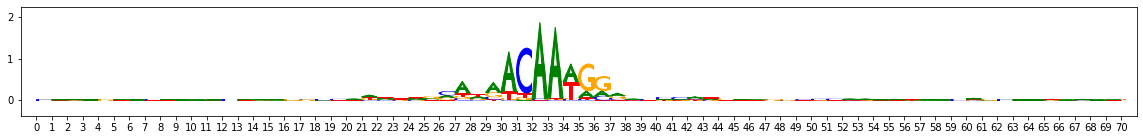

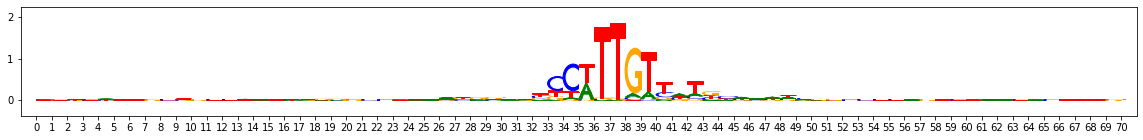

metacluster_0 pattern_1
total seqlets: 173
Hypothetical scores:


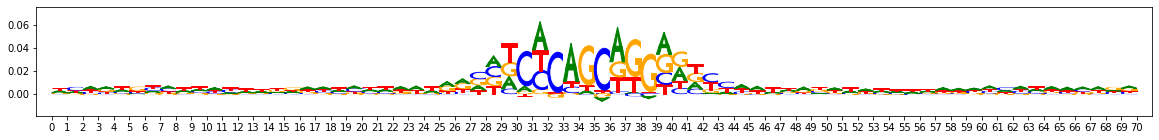

Actual importance scores:


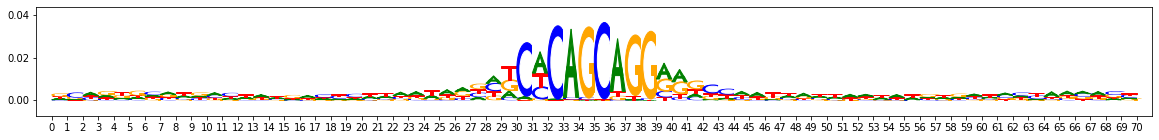

onehot, fwd and rev:


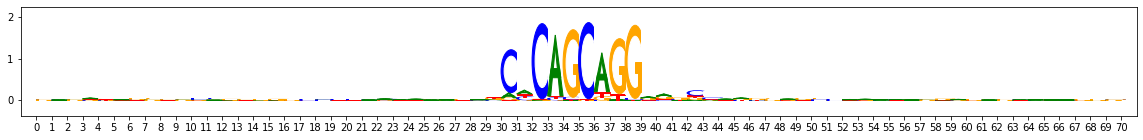

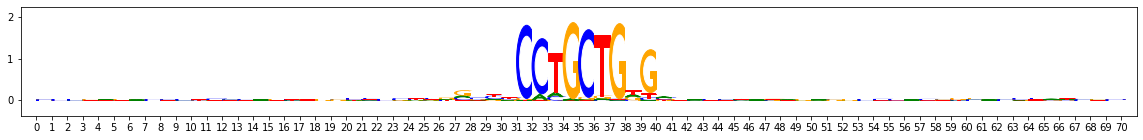

metacluster_0 pattern_2
total seqlets: 163
Hypothetical scores:


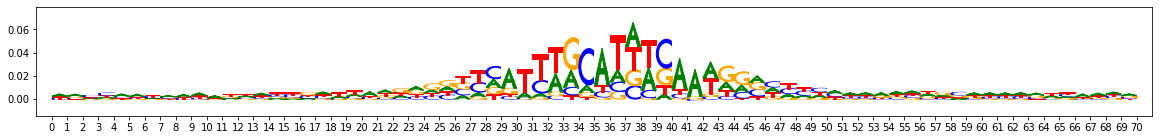

Actual importance scores:


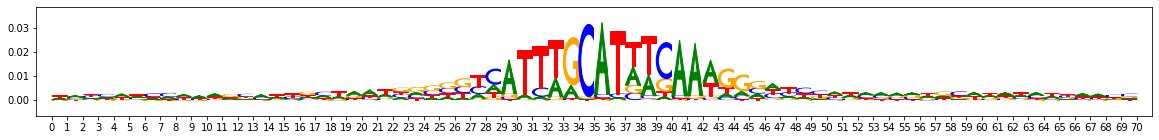

onehot, fwd and rev:


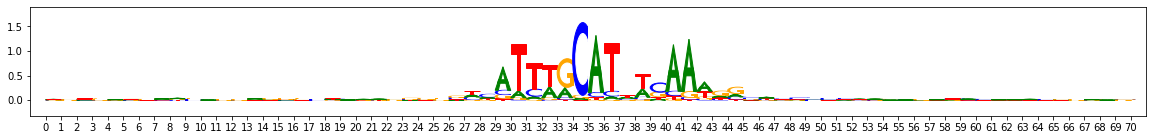

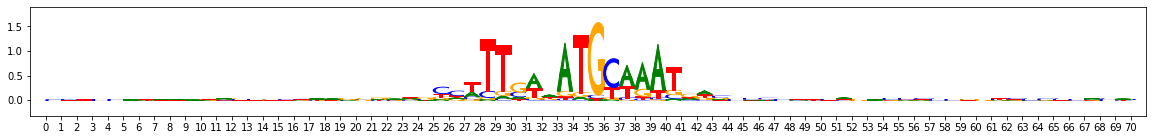

In [14]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()

In [ ]:
"""from modisco.visualization import viz_sequence
meme_discovered_motifs = (tfmodisco_results
    .metacluster_idx_to_submetacluster_results[0].seqlets_to_patterns_result
    .each_round_initcluster_motifs[0])
for idx,motif in enumerate(meme_discovered_motifs):
    print("MEME-DISco motif number",idx)
    print("num seqlets:",len(motif.seqlets))
    viz_sequence.plot_weights(motif["task0_contrib_scores"].fwd)
    viz_sequence.plot_weights(motif["sequence"].fwd)"""